In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy

# naive algo

/home/jaime/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jaime/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


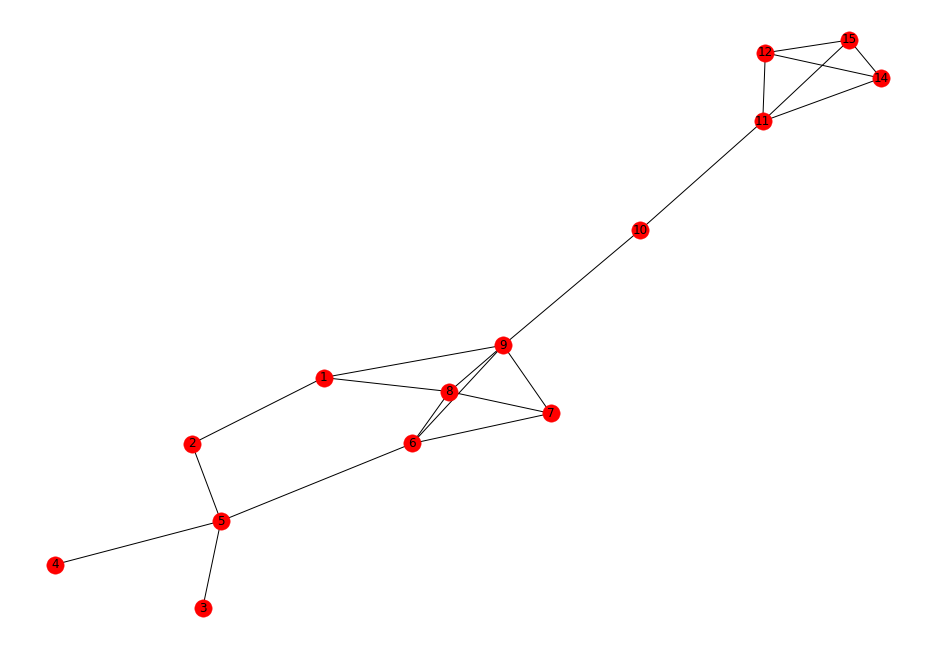

In [34]:
g = nx.Graph([])
g.add_edges_from([(1,2),(1,8),(1,9),
                  (5,2),
                  (5,3),
                  (5,4),
                  (5,6),
                  (6,7),
                  (6,8),
                  (6,9),
                  (7,8),
                  (7,9),
                  (8,9),
                  (9,10),
                  (10,11),
                  (11,14),
                  (11,15),
                  (11,12),
                  (14,15),
                  (15,12),
                  (12,14)
                 ])
nx.draw(g,with_labels=True)
plt.show()

In [34]:
def approche_naive(g):
    gg = copy.deepcopy(g)
    weights = dict(gg.degree)

    cores_g = dict(zip(gg.nodes,[0]*len(gg.nodes)))

    while len(gg.nodes) > 0:
        index_top , min_degree   = min(weights.items(), key=itemgetter(1))
        neighbors = list(gg.neighbors(index_top))
        cores_g[index_top] = min_degree
        gg.remove_node(index_top)
        weights.pop(index_top)

        if neighbors:
            new_degrees=gg.degree()
            for neigh in neighbors:
                weights[neigh] = max(min_degree,new_degrees[neigh])
                
    return cores_g

# Approach 1

In [23]:
def batagelj_naif(G):
    degrees = dict(G.degree())
    nodes = sorted(degrees, key=degrees.get)
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    i=0
    count_passed_through = []
    while len(count_passed_through)<len(nodes):
        nodes = sorted(degrees, key=degrees.get)       
        st =  set(count_passed_through)
        v = [ele for ele in nodes if ele not in st][0]  ### check mainting order

        for u in nbrs[v]:
            if degrees[u] > degrees[v]:
                degrees[u] -= 1
                
        count_passed_through.append(v)

    return degrees

In [24]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [25]:
%%cython
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy

def batagelj_naif_cython(G):
    degrees = dict(G.degree())
    nodes = sorted(degrees, key=degrees.get)
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    i=0
    count_passed_through = []
    while len(count_passed_through)<len(nodes):
        nodes = sorted(degrees, key=degrees.get)       
        st =  set(count_passed_through)
        v = [ele for ele in nodes if ele not in st][0]  ### check mainting order

        for u in nbrs[v]:
            if degrees[u] > degrees[v]:
                degrees[u] -= 1
                
        count_passed_through.append(v)

    return degrees

# Similaire nx

In [26]:
def batagelj_avance(G):
# inspiré, comme mentionné sur le rapport, du code source de NetworkX, (Hagberg, Schult, Swart)
    degrees = dict(G.degree())
    # Sort nodes by degree.
    nodes = sorted(degrees, key=degrees.get)
    bin_boundaries = [0]
    curr_degree = 0
    for i, v in enumerate(nodes):
        if degrees[v] > curr_degree:
            bin_boundaries.extend([i] * (degrees[v] - curr_degree))
            curr_degree = degrees[v]
    node_pos = {v: pos for pos, v in enumerate(nodes)}
    

    core = degrees
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    for v in nodes:
        for u in nbrs[v]:
            if core[u] > core[v]:
                nbrs[u].remove(v)
                pos = node_pos[u]
                bin_start = bin_boundaries[core[u]]
                node_pos[u] = bin_start
                node_pos[nodes[bin_start]] = pos
                nodes[bin_start], nodes[pos] = nodes[pos], nodes[bin_start]
                bin_boundaries[core[u]] += 1
                core[u] -= 1
    return core

# sanity check

On teste que nos approches soient bonnes sur un nombre suffisament important et divers de graphes

In [15]:
G = nx.duplication_divergence_graph(10**3,0.7)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [16]:
G = nx.balanced_tree(5,3)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [17]:
G = nx.circular_ladder_graph(150)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [18]:
G = nx.generators.random_graphs.gnm_random_graph(150,200)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

# Parallelized approaches

## Approach 1 : multithreading with Python

### Implementation

In [35]:
import networkx as nx
import numpy as np
from threading import Thread, Lock

In [36]:
# L'algorithme PKC fonctionne en mettant à jour itérativement et en parallèle
# le dictionnaire des degrés des noeuds.
# Afin de le protéger d'éventuelles race conditions, on protège sa lecture et son écriture
# en l'encapsulant dans une classe et en implémentant des threadlocks.
# On fait de même pour la variable visited qui donne le critère d'arrêt de l'algorithme.

class Counters():
    """Encapsule les compteurs dans une classe avec des threadlocks pour éviter les race conditions."""
    def __init__(self, G):
        G = G.copy()
        self.deg = dict(G.degree)
        self.visited = 0
        self.lock = Lock()

    def get_degree(self, node):
        with self.lock:
            return self.deg[node]

    def increment_degree(self, node, value):
        with self.lock:
            self.deg[node] += value
            return self.deg[node]

    def get_visited(self):
        with self.lock:
            return self.visited

    def increment_visited(self, value):
        with self.lock:
            self.visited += value

    def reinitialize(self, G):
        self.visited = 0
        self.deg = dict(G.degree)

In [37]:
def process_nodes(nodes_ind, G, counters, level):
    """Traite une séquence de noeuds de manière local sur un thread."""
    nodes_list = list(G.nodes)
    buff = np.zeros_like(nodes_list).astype(int)
    start = 0
    end = 0
    
    # On stocke les noeuds qui doivent être traités (i.e. tq current core == level)
    # dans un buffer local à chaque thread
    for i in nodes_ind:
        deg_i = counters.get_degree(nodes_list[i])
        if deg_i == level:
            buff[end] = i
            end += 1
    
    # Chaque thread traite séquentiellement les noeuds de son buffer en comparant
    # les degrés de ses voisins au niveau d'entrée (level)
    while start < end:
        v = buff[start]
        start += 1
        for u in G.neighbors(nodes_list[v]):
            if counters.get_degree(u) > level:
                a = counters.increment_degree(u, -1)
                if a == level:
                    buff[end] = nodes_list.index(u)
                    end += 1
                if a < level:
                    counters.increment_degree(u, 1)

    counters.increment_visited(end)

In [48]:
def pkc(G, n_threads=5):
    """Calcule une décomposition en K-core en parallélisant le traitement sur des threads."""
    G = G.copy()
    n = len(G.nodes)
    assert(n_threads < n)
    counters = Counters(G)

    nodes_split = np.array_split(range(n), n_threads)
    level = 0
    visited = 0
    thread_list = []
    
    # On traite des blocs de noeuds de taille n / n_threads en parallèle
    while visited < n:
        for t in range(n_threads):
            thread = Thread(target=process_nodes, args=(nodes_split[t],
                                                       G, counters, level))
            thread_list.append(thread)
            thread_list[t].start()
        for thread in thread_list:
            thread.join()
        thread_list = []

        level += 1
        visited = counters.get_visited()

    deg = counters.deg.copy()

    return deg

### Sanity check

In [49]:
n_threads = 5
assert(nx.core_number(g) == pkc(g, n_threads))

# approach comparison

In [50]:
from timeit import timeit
array_len_range= range(100,500,200)
functions = ['approche_naive','batagelj_naif','batagelj_avance','nx.core_number','pkc']
# labels = ['algorithme naif', 'batagelj basique', 'batagelj avancé', 'nx.core_number']
functions_arrays=[(i,[]) for i in functions]
x = [10*i for i in array_len_range]

for num,i in enumerate(x):
    num_iter = 4
    print(num)

    G = nx.duplication_divergence_graph(i,0.7)

    for function,array in functions_arrays:
        time = timeit(str(function + '(G)'), number=num_iter, globals=globals())/num_iter
        array.append(time)

0
1


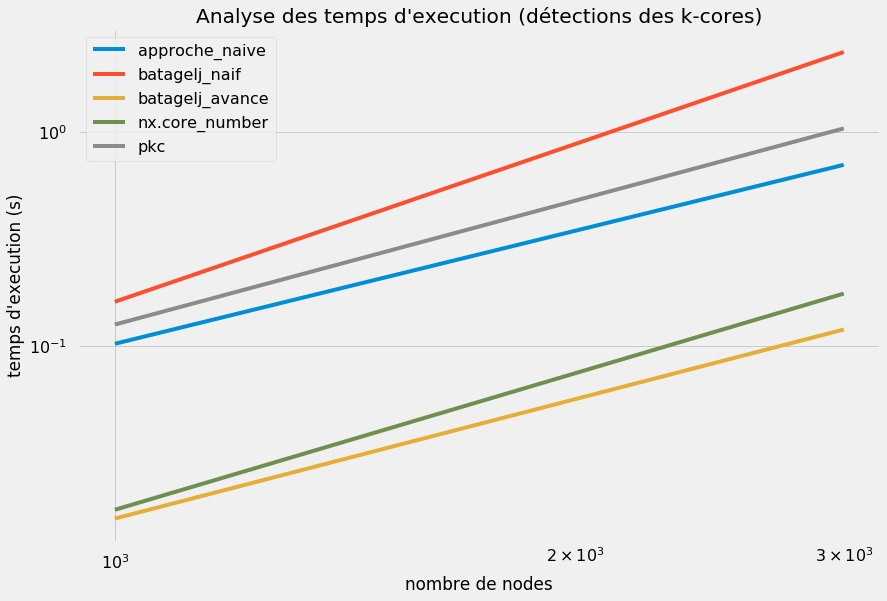

In [51]:

from matplotlib import pyplot as plt
import numpy as np


plt.style.use(['seaborn-poster','fivethirtyeight'])

# plt.style.use(['dark_background', 'presentation'])


fig, ax = plt.subplots()
for function,array in functions_arrays:
    ax.plot(x, array,label=function)

ax.set_title("Analyse des temps d'execution (détections des k-cores)")
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

plt.xlabel ("nombre de nodes")
plt.ylabel ("temps d'execution (s)")
plt.show()

## Approach 2 : multithreading with Cython + OpenMP